Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9


Wrote a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, November 26 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, November 27
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [36]:
import numpy as np
import random
from tqdm import tqdm
from copy import deepcopy

import lab9_lib

In [37]:
MU = 5
LAMBDA = 20
MUTATION_PROB = 0.2

LENGTH_SOLUTION = 1000
NUMBER_GENERATIONS = 1_500

In [38]:
def generate_random_individual():
    ind = np.random.choice([0, 1], size=LENGTH_SOLUTION)
    return ind

def mutate(ind, size=1, mutation_probability=MUTATION_PROB, stats=None):
    if np.random.randn() < mutation_probability:
        index = np.random.choice(list(range(len(ind))), size=size, replace=False, p=stats)
        ind[index] = 1 - ind[index]
    return ind

def reproduce(ind1, ind2):
    index = np.random.randint(0, len(ind1))
    new_ind = deepcopy(ind1)
    new_ind[index:] = ind2[index:]
    
    return new_ind

def reproduce1(ind1, ind2):
    new_ind = np.ndarray(shape=ind1.shape)
    for i in range(len(ind1)):
        gene_giver = random.choice([ind1, ind2])
        new_ind[i] = gene_giver[i]
    return new_ind


def get_diversity(people):
    divs = []
    for i in range(len(people)):
        for j in range(i, len(people)):
            divs.append( np.sum( np.abs( people[i]-people[j] ) ) )
    return np.array(divs).max()

def generate_pop(n):
    parents = []
    k = 0
    sep = 2**k
    while sep < LENGTH_SOLUTION:
        parents.append(np.array([0 if i < LENGTH_SOLUTION//sep else 1 for i in range(LENGTH_SOLUTION)]))
        parents.append(np.array([1 if i < LENGTH_SOLUTION//sep else 0 for i in range(LENGTH_SOLUTION)]))
        k += 1
        sep = 2**k

    print(len(parents))
    while len(parents) < n:
        p1 = random.choices(parents, k=1)[0]
        p2 = random.choices(parents, k=1)[0]
        new_ind = mutate(reproduce1(p1,p2), size=mut_size)
        parents.append(new_ind)

    return parents



In [39]:
fitness = lab9_lib.make_problem(2)
parents = [generate_random_individual() for _ in range(3000)] # 168600
# parents = generate_pop(1000) # 31mila
parents_evals = [fitness(x) for x in parents]

hist_mean = []
hist_std = []
div = []

mut_size = 1

pop_history = {}
for i in range(len(parents)):
    pop_history[parents[i].tobytes()] = parents_evals[i]

for generation in tqdm(range(NUMBER_GENERATIONS)):
    offsprings = []
    offsprings_evals = []

    if (max(parents_evals)-min(parents_evals)) > 1e-5:
        probabilities = [(score-min(parents_evals)) / (max(parents_evals)-min(parents_evals)) for score in parents_evals]
    else:
        probabilities = [1 for score in parents_evals]
    probabilities = np.array(probabilities)/sum(probabilities)
    while len(offsprings) < LAMBDA:
        p1 = random.choices(parents, k=1, weights=probabilities)[0]
        p2 = random.choices(parents, k=1, weights=probabilities)[0]
        
        div_parents = np.sum( np.abs( p1-p2 ) )
        div_threshold = 500
        new_ind = mutate(reproduce1(p1,p2), size=1 if div_parents < 10 else 3, \
                                            mutation_probability=(MUTATION_PROB)+(1-MUTATION_PROB)*(1-(min(div_threshold,div_parents)/div_threshold)))

        if pop_history.get(new_ind.tobytes()) != None:
            continue
        
        new_ind_eval = fitness(new_ind)
        offsprings.append(new_ind)
        offsprings_evals.append(new_ind_eval)
        pop_history[new_ind.tobytes()] = new_ind_eval

    all_people = parents + offsprings
    all_evals = parents_evals + offsprings_evals


    best_people = np.argsort(all_evals)[::-1]

    parents = []
    parents_evals = []
    for i in range(MU):
        parents.append(all_people[best_people[i]])
        parents_evals.append(all_evals[best_people[i]])

    if np.max(parents_evals) - 1.0 >= 0:
        print(f"Early stopping {generation=}")
        break

    ### INFOS
    hist_mean.append(np.mean(all_evals))
    hist_std.append(np.std(all_evals))
    div.append(get_diversity(parents))

i_best = np.argmax(parents_evals)
print(parents[i_best])
print("Best score: ", parents_evals[i_best])
print("Num fitness calls: ", fitness.calls)

 34%|███▍      | 511/1500 [00:12<00:24, 40.06it/s]

Early stopping generation=511
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0.

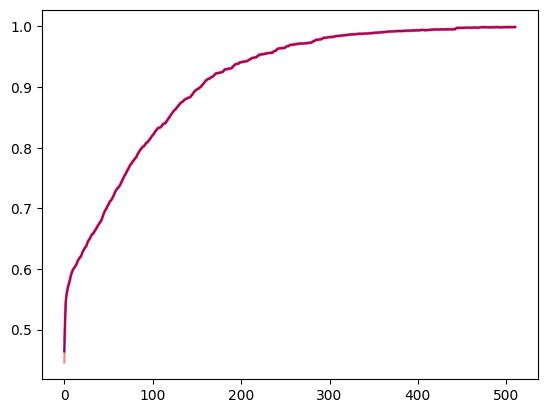

In [40]:
import matplotlib.pyplot as plt

hist_mean = np.array(hist_mean)
hist_std = np.array(hist_std)

plt.plot(hist_mean[:], c='blue')
plt.plot(hist_mean+hist_std, c='red', alpha=0.5)
plt.plot(hist_mean-hist_std, c='red', alpha=0.5)
plt.show()

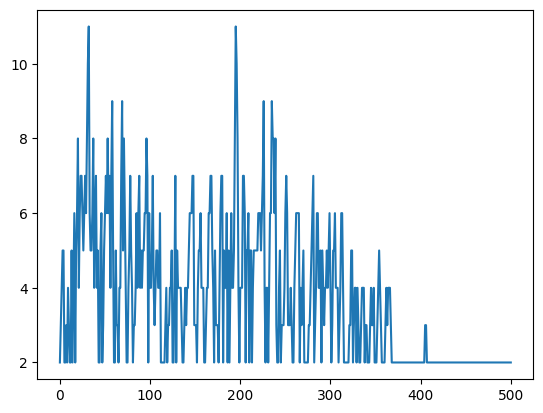

In [41]:

plt.plot(div[10:])
plt.show()